In [9]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ultralytics import YOLO
import torch
import cv2

In [10]:
def iou(boxA, boxB):
    # Calculates the Intersection over Union (IoU) between two bounding boxes.
    
    # Each box is expected in the format [x1, y1, x2, y2],
    # where (x1, y1) is the top-left corner, and (x2, y2) is the bottom-right.
    
    # Determine the coordinates of the intersection rectangle
    x1 = max(boxA[0], boxB[0])  # leftmost x of the overlap
    y1 = max(boxA[1], boxB[1])  # topmost y of the overlap
    x2 = min(boxA[2], boxB[2])  # rightmost x of the overlap
    y2 = min(boxA[3], boxB[3])  # bottommost y of the overlap
    
    # Calculate width and height of the intersection
    inter_w = max(0, x2 - x1)
    inter_h = max(0, y2 - y1)
    intersection = inter_w * inter_h  # area of overlap
    
    # Compute area of each bounding box
    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    
    # Union is sum of areas minus the intersection
    union = areaA + areaB - intersection
    
    # Return IoU, adding a small epsilon to avoid division by zero
    return intersection / (union + 1e-6)


Using device: cuda
Large image shape: (800, 800, 3)
Window size: 200x200, stride: 100

Collected 14 raw boxes from sub-windows.
Total boxes before NMS: 14, after NMS: 4


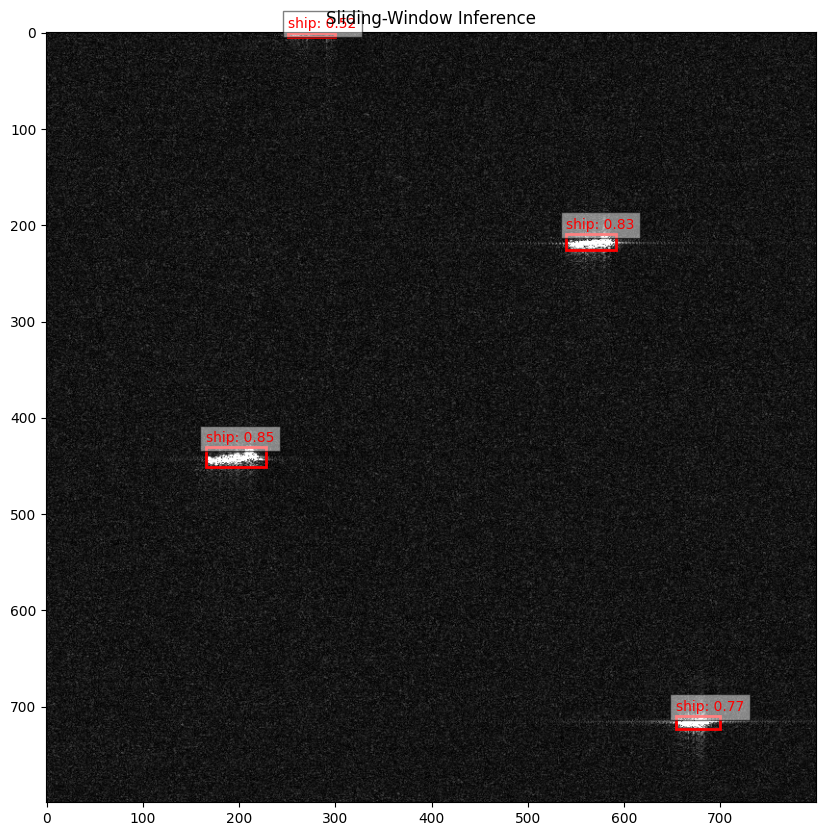

In [11]:
model_path = "/home/tjriz/Documents/Senior-Design/YOLOv11_training_HRSID/runs/detect/HRSID_update-tj/weights/best.pt"

large_image_path = "/home/tjriz/Documents/Senior-Design/datasets/HRSID/images/P0001_2400_3200_4200_5000.png"

model = YOLO(model_path)

# Ensure that GPU is available and that model is moved there
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(f"Using device: {device}")

# Load the large image with PIL package then convert to NumPy
with Image.open(large_image_path) as pil_img:
    pil_img = pil_img.convert("RGB")
    large_image = np.array(pil_img)

H, W, _ = large_image.shape
print(f"Large image shape: {large_image.shape}")

# Sliding window parameters
window_width, window_height = 200, 200
stride = 100
print(f"Window size: {window_width}x{window_height}, stride: {stride}")

# Sliding window inferencing
all_boxes = []  # will store [x1, y1, x2, y2, conf, class_id]

for y in range(0, H, stride):
    # If this window goes beyond the bottom "clamp" once and then break
    if y + window_height > H:
        y = H - window_height

    for x in range(0, W, stride):
        # If this window goes beyond the right edge "clamp" once and then break
        if x + window_width > W:
            x = W - window_width
        
        # Extract the subwindow
        sub_patch = large_image[y : y + window_height, x : x + window_width, :]

        # Run YOLOv11 model on the patch using best weights
        results = model.predict(sub_patch, conf=0.3, verbose=False, device=device)
        
        # Collect detections
        if len(results) > 0:
            dets = results[0].boxes
            for det in dets:
                x1, y1, x2, y2 = det.xyxy[0].tolist()
                conf = det.conf[0].item()
                cls_id = int(det.cls[0].item())

                # Convert subwindow coordinates to full-sized image coordinates
                global_x1 = x + x1
                global_y1 = y + y1
                global_x2 = x + x2
                global_y2 = y + y2

                all_boxes.append([global_x1, global_y1, global_x2, global_y2, conf, cls_id])

        # After doing the clamped right edge break out so we don’t toggle back
        if x + window_width >= W:
            break

    # After doing the clamped bottom edge break out
    if y + window_height >= H:
        break

print(f"\nCollected {len(all_boxes)} raw boxes from sub-windows.")

# Non-Maximum Suppression (NMS) to compress overlapping detections/boxes
final_boxes = []

if len(all_boxes) == 0:
    print("No detections found at all.")
else:
    # Convert to NumPy array
    boxes_array = np.array(all_boxes)  # shape (N, 6): [x1, y1, x2, y2, conf, cls]
    # Sort by confidence descending
    sorted_indices = np.argsort(boxes_array[:, 4])[::-1]

    # This value can be changed as needed, but 0.5 did not properly combine some of the overlapping bounding boxes
    nms_threshold = 0.4
    
    keep = []
    while len(sorted_indices) > 0:
        current_idx = sorted_indices[0]
        keep.append(current_idx)
        
        if len(sorted_indices) == 1:
            break
        
        remaining_idxs = sorted_indices[1:]
        ious = [iou(boxes_array[current_idx], boxes_array[idx]) for idx in remaining_idxs]
        mask = np.array(ious) < nms_threshold
        sorted_indices = remaining_idxs[mask]

    final_boxes = boxes_array[keep]
    print(f"Total boxes before NMS: {len(all_boxes)}, after NMS: {len(final_boxes)}")

# Visualization using Matplotlib
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(large_image)

for box in final_boxes:
    x1, y1, x2, y2, conf, cls_id = box

    # Convert numeric class ID to string label
    class_name = model.names[int(cls_id)]
    
    rect = patches.Rectangle(
        (x1, y1), (x2 - x1), (y2 - y1),
        linewidth=2, edgecolor='red', facecolor='none'
    )
    ax.add_patch(rect)
    
    # Overlaying text with class and confidence value
    # label = f"Class {int(cls_id)}: {conf:.2f}"
    label = f"{class_name}: {conf:.2f}"
    ax.text(x1, y1 - 5, label, color='red', bbox=dict(facecolor='white', alpha=0.5))

plt.title("Sliding-Window Inference")
plt.show()


In [13]:
large_image_bgr = cv2.imread(large_image_path)
H, W, _ = large_image_bgr.shape
window_width, window_height = 200, 200
stride = 100
all_boxes = []

for y in range(0, H, stride):
    if y + window_height > H:
        y = H - window_height
    for x in range(0, W, stride):
        if x + window_width > W:
            x = W - window_width
        sub_patch = large_image_bgr[y:y+window_height, x:x+window_width]
        results = model.predict(sub_patch, conf=0.3, verbose=False, device=device)
        if len(results) > 0:
            dets = results[0].boxes
            for det in dets:
                x1, y1, x2, y2 = det.xyxy[0].tolist()
                conf = det.conf[0].item()
                cls_id = int(det.cls[0].item())
                global_x1 = x + x1
                global_y1 = y + y1
                global_x2 = x + x2
                global_y2 = y + y2
                all_boxes.append([global_x1, global_y1, global_x2, global_y2, conf, cls_id])
        if x + window_width >= W:
            break
    if y + window_height >= H:
        break

if not all_boxes:
    final_boxes = []
else:
    boxes_array = np.array(all_boxes)
    sorted_indices = np.argsort(boxes_array[:, 4])[::-1]
    nms_threshold = 0.4
    keep = []
    while len(sorted_indices) > 0:
        current_idx = sorted_indices[0]
        keep.append(current_idx)
        if len(sorted_indices) == 1:
            break
        remaining_idxs = sorted_indices[1:]
        ious = [iou(boxes_array[current_idx], boxes_array[idx]) for idx in remaining_idxs]
        mask = np.array(ious) < nms_threshold
        sorted_indices = remaining_idxs[mask]
    final_boxes = boxes_array[keep]

for box in final_boxes:
    x1, y1, x2, y2, conf, cls_id = box
    label = f"{model.names[int(cls_id)]}: {conf:.2f}"
    cv2.rectangle(
        large_image_bgr,
        (int(x1), int(y1)),
        (int(x2), int(y2)),
        (0, 0, 255),
        2
    )
    text_y = max(int(y1) - 5, 0)
    cv2.putText(
        large_image_bgr,
        label,
        (int(x1), text_y),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.6,
        (0, 0, 255),
        2
    )

cv2.namedWindow("Detections", cv2.WINDOW_NORMAL)
cv2.resizeWindow("Detections", 1280, 720)
cv2.imshow("Detections", large_image_bgr)
cv2.waitKey(0)
cv2.destroyAllWindows()